In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

sns.set_palette("pastel")

## Анализ

#### Датасет по страховке

#### Столбцы:

* **Charges** - расходы
* **Sex** - пол
* **Age** - возраст
* **Bmi** - индекс массы тела
* **Smoker** - курит ли человек
* **Children** - количество детей
* **Region** - регион

In [5]:
df = pd.read_csv('insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [6]:
df.shape

(1338, 7)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [8]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [9]:
df.duplicated().sum()

np.int64(1)

In [10]:
df = df.drop_duplicates()

In [11]:
df['region'].value_counts()

region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64

In [12]:
df.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1337.000000,1337.000000
mean,39.222139,30.663452,1.095737,13279.121487
std,14.044333,6.100468,1.205571,12110.359656
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4746.344000
50%,39.000000,30.400000,1.000000,9386.161300
75%,51.000000,34.700000,2.000000,16657.717450
max,64.000000,53.130000,5.000000,63770.428010


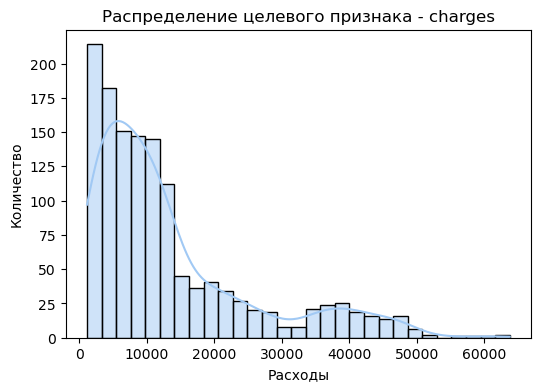

In [13]:
plt.figure(figsize=(6,4))
plt.title('Распределение целевого признака - charges')
sns.histplot(df['charges'], kde=True)
plt.xlabel('Расходы')
plt.ylabel('Количество')
plt.show()

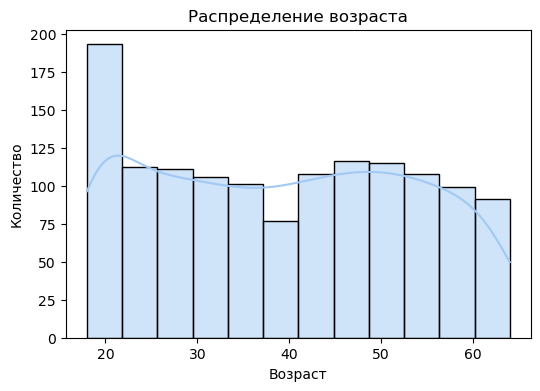

In [14]:
plt.figure(figsize=(6,4))
plt.title('Распределение возраста')
sns.histplot(df['age'], kde=True)
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

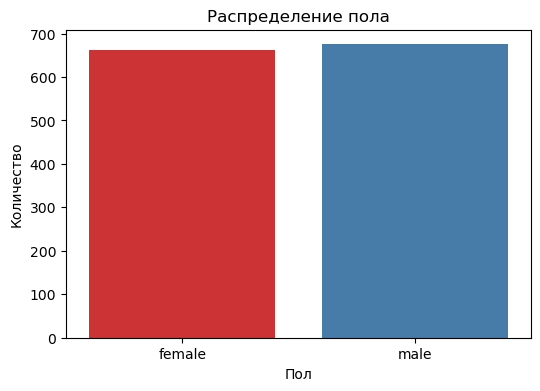

In [15]:
plt.figure(figsize=(6,4))
sns.countplot(x='sex', data=df, hue='sex', palette='Set1')
plt.title('Распределение пола')
plt.xlabel('Пол')
plt.ylabel('Количество')
plt.show()

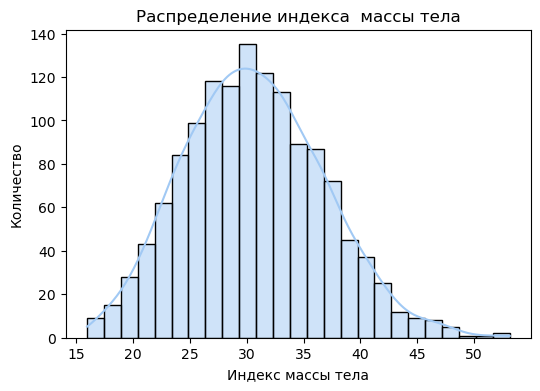

In [16]:
plt.figure(figsize=(6,4))
sns.histplot(df['bmi'], kde=True)
plt.title('Распределение индекса  массы тела')
plt.xlabel('Индекс массы тела')
plt.ylabel('Количество')
plt.show()

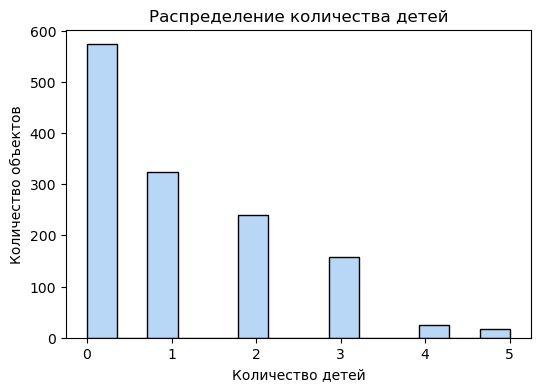

In [17]:
plt.figure(figsize=(6,4))
sns.histplot(df['children'])
plt.title('Распределение количества детей')
plt.xlabel('Количество детей')
plt.ylabel('Количество объектов')
plt.show()

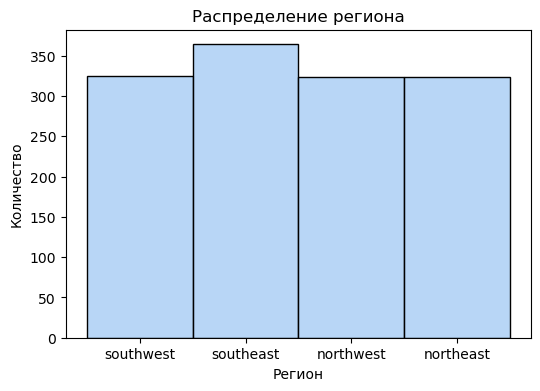

In [18]:
plt.figure(figsize=(6,4))
sns.histplot(df['region'])
plt.title('Распределение региона')
plt.xlabel('Регион')
plt.ylabel('Количество')
plt.show()

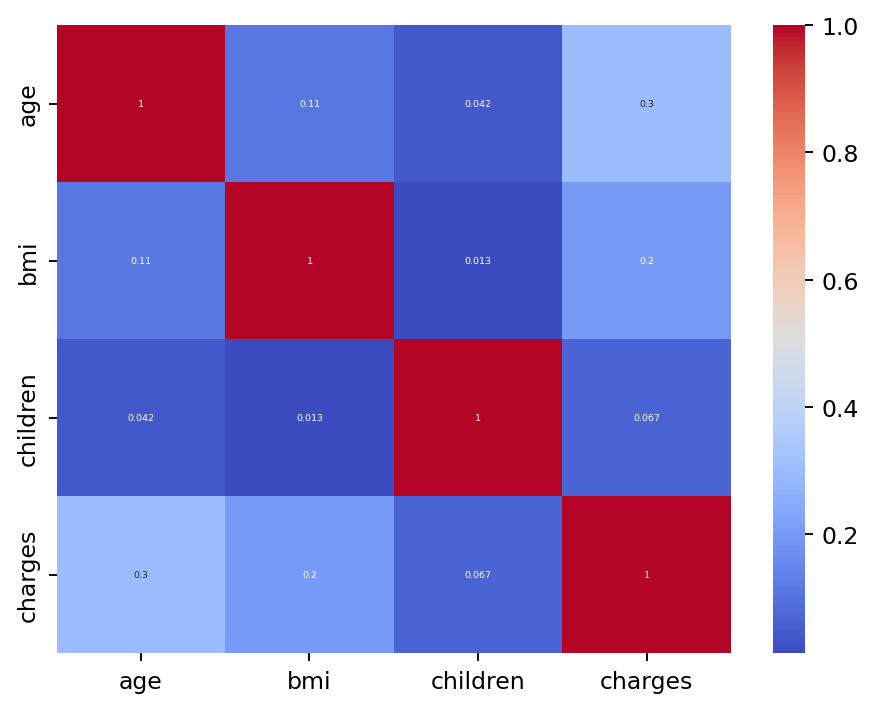

In [19]:
corr = df.select_dtypes(include=np.number).corr()
plt.figure(dpi=170)
sns.heatmap(corr, annot=True, annot_kws={'size':4}, cmap='coolwarm')
plt.show()

In [20]:
X = df.drop(columns=['charges'])
y_log = np.log1p(df['charges'])

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


In [22]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_features

Index(['age', 'bmi', 'children'], dtype='object')

In [23]:
categorical_features = X.select_dtypes(include=['object', 'category']).columns
categorical_features

Index(['sex', 'smoker', 'region'], dtype='object')

In [24]:
X[categorical_features].nunique()

sex       2
smoker    2
region    4
dtype: int64

In [25]:
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numeric_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_features)
])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)
preprocessed_X_train = preprocessor.fit_transform(X_train)
preprocessed_X_test = preprocessor.transform(X_test)

In [27]:
features_name = preprocessor.get_feature_names_out()
features_name

array(['num__age', 'num__bmi', 'num__children', 'cat__sex_female',
       'cat__sex_male', 'cat__smoker_no', 'cat__smoker_yes',
       'cat__region_northeast', 'cat__region_northwest',
       'cat__region_southeast', 'cat__region_southwest'], dtype=object)

In [28]:
len(features_name)

11

## Линейная регрессия

In [29]:
linear_model = LinearRegression()
linear_model.fit(preprocessed_X_train, y_train)

y_linear_pred = linear_model.predict(preprocessed_X_test)

In [97]:
y_linear_pred_real = np.expm1(y_linear_pred)
y_test_real = np.expm1(y_test)
y_train_real = np.expm1(y_train)

In [31]:
linear_test_mse = mean_squared_error(y_test_real, y_linear_pred_real)
linear_test_mae = mean_absolute_error(y_test_real, y_linear_pred_real)
linear_test_r2 = r2_score(y_test_real, y_linear_pred_real)

In [32]:
linear_test_mse

51797278.35154593

In [33]:
linear_test_mae

3755.924575909673

In [34]:
linear_test_r2

0.7181193522954387

## Метод опорных векторов

In [35]:
svr_model = SVR(kernel='poly', C=500.0, epsilon=1.0)
svr_model.fit(preprocessed_X_train, y_train)

y_svr_pred = svr_model.predict(preprocessed_X_test)

In [36]:
y_svr_pred_real = np.expm1(y_svr_pred)

In [37]:
svr_test_mse = mean_squared_error(y_test_real, y_svr_pred_real)
svr_test_mae = mean_absolute_error(y_test_real, y_svr_pred_real)
svr_test_r2 = r2_score(y_test_real, y_svr_pred_real)

In [38]:
svr_test_mse

109771226.9896023

In [39]:
svr_test_mae

7343.48971062153

In [40]:
svr_test_r2

0.40262528171559764

Оптимизация

In [41]:
svr_space = {
    'C': hp.loguniform('C', np.log(1e-2), np.log(1e3)),
    'epsilon': hp.loguniform('eps', np.log(1e-3), np.log(1.0)),
    'gamma': hp.loguniform('gamma', np.log(1e-4), np.log(1.0)),
}

In [42]:
def objective(params):
    svr_model = SVR(kernel='poly',
                C=float(params['C']),
                epsilon=float(params['epsilon']),
                gamma=float(params['gamma']))
    
    svr_model.fit(preprocessed_X_train, y_train)
    
    y_svr_pred = svr_model.predict(preprocessed_X_test)
    
    y_svr_pred_real = np.expm1(y_svr_pred)

    rmse = np.sqrt(mean_squared_error(y_test_real, y_svr_pred_real))
    return {'loss': rmse, 'status': STATUS_OK}

In [43]:
trials = Trials()
best = fmin(fn=objective, space=svr_space, algo=tpe.suggest,
            max_evals=15, trials=trials, rstate=np.random.default_rng(42))
best

100%|██████████| 15/15 [00:18<00:00,  1.24s/trial, best loss: 4617.027431520174]


{'C': np.float64(262.80469968662425),
 'eps': np.float64(0.07250316961973834),
 'gamma': np.float64(0.179730437123319)}

In [44]:
svr_best = SVR(kernel="rbf",
               C=float(best["C"]),
               epsilon=float(best["eps"]),
               gamma=float(best["gamma"]))

svr_best.fit(preprocessed_X_train, y_train)
y_svr_best_pred = svr_best.predict(preprocessed_X_test)

In [45]:
y_svr_best_pred_real = np.expm1(y_svr_best_pred)

svr_best_test_mse = mean_squared_error(y_test_real, y_svr_best_pred_real)
svr_best_test_mae = mean_absolute_error(y_test_real, y_svr_best_pred_real)
svr_best_test_r2 = r2_score(y_test_real, y_svr_best_pred_real)

In [46]:
svr_best_test_mse

46130587.42996253

In [47]:
svr_best_test_mae

3636.59490303023

In [48]:
svr_best_test_r2

0.7489574688558586

## Дерево решений

In [49]:
dt = DecisionTreeRegressor(random_state=42, max_depth=8, min_samples_leaf=10, min_samples_split=20)
dt.fit(preprocessed_X_train, y_train)

y_dt_pred = dt.predict(preprocessed_X_test)

In [50]:
y_dt_pred_real = np.expm1(y_dt_pred)

dt_test_mse = mean_squared_error(y_test_real, y_dt_pred_real)
dt_test_mae = mean_absolute_error(y_test_real, y_dt_pred_real)
dt_test_r2 = r2_score(y_test_real, y_dt_pred_real)

In [51]:
dt_test_mse

18074571.30434407

In [52]:
dt_test_mae

2129.011506195126

In [53]:
dt_test_r2

0.9016382321929715

Оптимизация

In [54]:
dt_space = {
    "max_depth": hp.quniform("max_depth", 3, 30, 1),
    "min_samples_leaf": hp.qloguniform("min_samples_leaf", np.log(1), np.log(50), 1),
    "min_samples_split": hp.qloguniform("min_samples_split", np.log(2), np.log(100), 1),
}

In [55]:
def objective(params):
    dt_model = DecisionTreeRegressor(
        random_state=42,
        max_depth=int(params["max_depth"]),
        min_samples_leaf=int(params["min_samples_leaf"]),
        min_samples_split=int(params["min_samples_split"])
    )
    dt_model.fit(preprocessed_X_train, y_train)

    y_dt_pred = dt.predict(preprocessed_X_test)
    
    y_dt_pred_real = np.expm1(y_dt_pred)
    
    rmse = np.sqrt(mean_squared_error(y_test_real, y_dt_pred_real))
    return {"loss": rmse, "status": STATUS_OK}

trials = Trials()
best = fmin(fn=objective, space=dt_space, algo=tpe.suggest,
            max_evals=60, trials=trials, rstate=np.random.default_rng(42))
best

100%|██████████| 60/60 [00:00<00:00, 93.05trial/s, best loss: 4251.419916256693] 


{'max_depth': np.float64(27.0),
 'min_samples_leaf': np.float64(11.0),
 'min_samples_split': np.float64(48.0)}

In [56]:
dt_best_model = DecisionTreeRegressor(
        random_state=42,
        max_depth=int(best["max_depth"]),
        min_samples_leaf=int(best["min_samples_leaf"]),
        min_samples_split=int(best["min_samples_split"])
    )

dt_best_model.fit(preprocessed_X_train, y_train)

y_dt_best_pred = dt_best_model.predict(preprocessed_X_test)
    
y_dt_best_pred_real = np.expm1(y_dt_best_pred)

In [57]:
dt_best_test_mse = mean_squared_error(y_test_real, y_dt_best_pred_real)
dt_best_test_mae = mean_absolute_error(y_test_real, y_dt_best_pred_real)
dt_best_test_r2 = r2_score(y_test_real, y_dt_best_pred_real)

In [58]:
dt_best_test_mse

18435424.608086236

In [59]:
dt_best_test_mae

2270.9376961357425

In [60]:
dt_best_test_r2

0.8996744694968928

#### Random Forest

In [80]:
rf_model = RandomForestRegressor(n_estimators=600, random_state=42)
rf_model.fit(preprocessed_X_train, y_train)

y_rf_pred = rf_model.predict(preprocessed_X_test)

In [81]:
y_rf_pred_real = np.expm1(y_rf_pred)

rf_test_mse = mean_squared_error(y_test_real, y_rf_pred_real)
rf_test_mae = mean_absolute_error(y_test_real, y_rf_pred_real)
rf_test_r2 = r2_score(y_test_real, y_rf_pred_real)

In [82]:
rf_test_mse

18940671.751110155

In [83]:
rf_test_mae

2042.2989380999134

In [84]:
rf_test_r2

0.8969249159207402

Train:

In [98]:
y_rf_train_pred = rf_model.predict(preprocessed_X_train)

y_rf_train_pred_real = np.expm1(y_rf_train_pred)

rf_train_mse = mean_squared_error(y_train_real, y_rf_train_pred_real)
rf_train_mae = mean_absolute_error(y_train_real, y_rf_train_pred_real)
rf_train_r2 = r2_score(y_train_real, y_rf_train_pred_real)

In [99]:
rf_train_mse

5364525.583608879

In [100]:
rf_train_mae

953.9300374740304

In [101]:
rf_train_r2

0.9608184749018448

Оптимизация

In [88]:
rf_space = {
    "n_estimators": hp.quniform("n_estimators", 200, 800, 50),
    "max_depth": hp.choice("max_depth", [None, 6, 8, 10, 12, 16, 20]),
    "min_samples_split": hp.qloguniform("min_samples_split", np.log(2), np.log(100), 1),
    "min_samples_leaf": hp.qloguniform("min_samples_leaf",  np.log(1), np.log(50),  1),
    "max_features": hp.choice("max_features", ["sqrt", "log2", 0.3, 0.5, 0.7]),
}

In [89]:
def objective(params):
    rf_model = RandomForestRegressor(
        n_estimators=int(params["n_estimators"]),
        max_depth=params["max_depth"],
        min_samples_split=int(params["min_samples_split"]),
        min_samples_leaf=int(params["min_samples_leaf"]),
        max_features=params["max_features"],
        n_jobs=-1,
        random_state=42
    )
    
    rf_model.fit(preprocessed_X_train, y_train)
    y_rf_pred_log = rf_model.predict(preprocessed_X_test)

    y_rf_pred = np.expm1(y_rf_pred_log)

    rmse = np.sqrt(mean_squared_error(y_test_real, y_rf_pred))
    return {"loss": rmse, "status": STATUS_OK}

trials = Trials()
best = fmin(fn=objective, space=rf_space, algo=tpe.suggest,
            max_evals=40, trials=trials, rstate=np.random.default_rng(42))

best

100%|██████████| 40/40 [00:44<00:00,  1.12s/trial, best loss: 4230.801087830308]


{'max_depth': np.int64(5),
 'max_features': np.int64(4),
 'min_samples_leaf': np.float64(5.0),
 'min_samples_split': np.float64(6.0),
 'n_estimators': np.float64(450.0)}

In [91]:
rf_best_model = RandomForestRegressor(
        n_estimators=int(best["n_estimators"]),
        max_depth=best["max_depth"],
        min_samples_split=int(best["min_samples_split"]),
        min_samples_leaf=int(best["min_samples_leaf"]),
        max_features=best["max_features"],
        n_jobs=-1,
        random_state=42
    )

rf_best_model.fit(preprocessed_X_train, y_train)

y_rf_best_pred = rf_best_model.predict(preprocessed_X_test)
    
y_rf_best_pred_real = np.expm1(y_rf_best_pred)

In [92]:
rf_best_test_mse = mean_squared_error(y_test_real, y_rf_best_pred_real)
rf_best_test_mae = mean_absolute_error(y_test_real, y_rf_best_pred_real)
rf_best_test_r2 = r2_score(y_test_real, y_rf_best_pred_real)

In [93]:
rf_best_test_mse

23754553.689347196

In [94]:
rf_best_test_mae

2635.0018149934344

In [95]:
rf_best_test_r2

0.8707277835248246

Train:

In [102]:
y_rf_train_pred = rf_best_model.predict(preprocessed_X_train)

y_rf_train_pred_real = np.expm1(y_rf_train_pred)

rf_train_mse = mean_squared_error(y_train_real, y_rf_train_pred_real)
rf_train_mae = mean_absolute_error(y_train_real, y_rf_train_pred_real)
rf_train_r2 = r2_score(y_train_real, y_rf_train_pred_real)

In [103]:
rf_train_mse

22331368.195711125

In [104]:
rf_train_mae

2415.295552407183

In [105]:
rf_train_r2

0.836895723620023

## GB (Gradient Boosting)

In [123]:
from sklearn.ensemble import GradientBoostingRegressor

In [139]:
gb = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

gb.fit(preprocessed_X_train, y_train)
y_gb_pred = gb.predict(preprocessed_X_test)

In [140]:
y_gb_pred_real = np.expm1(y_gb_pred)

gb_test_mse = mean_squared_error(y_test_real, y_gb_pred_real)
gb_test_mae = mean_absolute_error(y_test_real, y_gb_pred_real)
gb_test_r2 = r2_score(y_test_real, y_gb_pred_real)

In [141]:
gb_test_mse

24647311.798852295

In [142]:
gb_test_mae

2627.022071235927

In [143]:
gb_test_r2

0.8658693963245773

Train:

In [144]:
y_gb_pred = gb.predict(preprocessed_X_train)
y_gb_pred_real = np.expm1(y_gb_pred)

gb_test_mse = mean_squared_error(y_train_real, y_gb_pred_real)
gb_test_mae = mean_absolute_error(y_train_real, y_gb_pred_real)
gb_test_r2 = r2_score(y_train_real, y_gb_pred_real)

In [145]:
gb_test_mse

16079565.290282322

In [146]:
gb_test_mae

1881.4162376028942

In [147]:
gb_test_r2

0.8825577618804481

Оптимизация:

In [148]:
gb_space = {
    "n_estimators": hp.quniform("n_estimators", 100, 800, 50),
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.2)),
    "max_depth": hp.quniform("max_depth", 2, 6, 1),
    "min_samples_split": hp.qloguniform("min_samples_split", np.log(2), np.log(50), 1),
    "min_samples_leaf": hp.qloguniform("min_samples_leaf", np.log(1), np.log(30), 1)
}

In [149]:
def objective(params):
    gb_model = GradientBoostingRegressor(
        n_estimators=int(params["n_estimators"]),
        learning_rate=float(params["learning_rate"]),
        max_depth=int(params["max_depth"]),
        min_samples_split=int(params["min_samples_split"]),
        min_samples_leaf=int(params["min_samples_leaf"]),
        random_state=42
    )
    
    gb_model.fit(preprocessed_X_train, y_train)
    y_gb_pred_log = gb_model.predict(preprocessed_X_test)

    y_gb_pred = np.expm1(y_gb_pred_log)

    rmse = np.sqrt(mean_squared_error(y_test_real, y_gb_pred))
    return {"loss": rmse, "status": STATUS_OK}

trials = Trials()
best = fmin(fn=objective, space=rf_space, algo=tpe.suggest,
            max_evals=40, trials=trials, rstate=np.random.default_rng(42))

best

100%|██████████| 40/40 [00:25<00:00,  1.58trial/s, best loss: 4226.219588927494]


{'learning_rate': np.float64(0.010660304112871265),
 'max_depth': np.float64(4.0),
 'min_samples_leaf': np.float64(10.0),
 'min_samples_split': np.float64(6.0),
 'n_estimators': np.float64(500.0)}

In [150]:
gb_model = GradientBoostingRegressor(
        n_estimators=int(best["n_estimators"]),
        learning_rate=float(best["learning_rate"]),
        max_depth=int(best["max_depth"]),
        min_samples_split=int(best["min_samples_split"]),
        min_samples_leaf=int(best["min_samples_leaf"]),
        random_state=42
    )
    
gb_model.fit(preprocessed_X_train, y_train)
y_gb_pred_log = gb_model.predict(preprocessed_X_test)

In [151]:
y_gb_pred_real = np.expm1(y_gb_pred_log)

gb_test_mse = mean_squared_error(y_test_real, y_gb_pred_real)
gb_test_mae = mean_absolute_error(y_test_real, y_gb_pred_real)
gb_test_r2 = r2_score(y_test_real, y_gb_pred_real)

In [152]:
gb_test_mse

17860932.01383448

In [153]:
gb_test_mae

1973.2385230254722

In [154]:
gb_test_r2

0.9028008566300176

## XGBoost

In [158]:
from xgboost import XGBRegressor

In [159]:
xgb = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    random_state=42,
    n_jobs=-1
)

xgb.fit(preprocessed_X_train, y_train)
y_xgb_pred = xgb.predict(preprocessed_X_test)

In [160]:
y_xgb_pred_real = np.expm1(y_xgb_pred)

xgb_test_mse = mean_squared_error(y_test_real, y_xgb_pred_real)
xgb_test_mae = mean_absolute_error(y_test_real, y_xgb_pred_real)
xgb_test_r2 = r2_score(y_test_real, y_xgb_pred_real)

In [161]:
xgb_test_mse

39701326.4443683

In [162]:
xgb_test_mae

2957.5004191535095

In [163]:
xgb_test_r2

0.7839454896275498

Оптимизация:

In [164]:
xgb_space = {
    "n_estimators": hp.quniform("n_estimators", 300, 1500, 50),
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),
    "max_depth": hp.quniform("max_depth", 3, 10, 1),
    "min_child_weight": hp.loguniform("min_child_weight", np.log(1), np.log(20)),
    "subsample": hp.uniform("subsample", 0.6, 1.0),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.6, 1.0),
    "reg_lambda": hp.loguniform("reg_lambda", np.log(1e-3), np.log(10.0)),
    "reg_alpha": hp.loguniform("reg_alpha", np.log(1e-6), np.log(1.0))
}

In [171]:
def objective(params):
    xgb = XGBRegressor(
        n_estimators=int(params["n_estimators"]),
        learning_rate=float(params["learning_rate"]),
        max_depth=int(params["max_depth"]),
        min_child_weight=float(params["min_child_weight"]),
        subsample=float(params["subsample"]),
        colsample_bytree=float(params["colsample_bytree"]),
        reg_lambda=float(params["reg_lambda"]),
        reg_alpha=float(params["reg_alpha"]),
        random_state=42,
        n_jobs=-1
    )
    
    xgb.fit(preprocessed_X_train, y_train)

    y_xgb_pred_log = xgb.predict(preprocessed_X_test)
    y_xgb_pred = np.expm1(y_xgb_pred_log)

    rmse = np.sqrt(mean_squared_error(y_test_real, y_xgb_pred))
    return {"loss": rmse, "status": STATUS_OK}

trials = Trials()
best = fmin(fn=objective, space=xgb_space, algo=tpe.suggest,
            max_evals=40, trials=trials, rstate=np.random.default_rng(42))

best

100%|██████████| 40/40 [00:16<00:00,  2.47trial/s, best loss: 4280.901598726655]


{'colsample_bytree': np.float64(0.8336363608297255),
 'learning_rate': np.float64(0.010192846361566919),
 'max_depth': np.float64(3.0),
 'min_child_weight': np.float64(1.7979616726533683),
 'n_estimators': np.float64(750.0),
 'reg_alpha': np.float64(0.005778576714037775),
 'reg_lambda': np.float64(0.31183014199029163),
 'subsample': np.float64(0.9704154380016944)}

In [172]:
xgb = XGBRegressor(
        n_estimators=int(best["n_estimators"]),
        learning_rate=float(best["learning_rate"]),
        max_depth=int(best["max_depth"]),
        min_child_weight=float(best["min_child_weight"]),
        subsample=float(best["subsample"]),
        colsample_bytree=float(best["colsample_bytree"]),
        reg_lambda=float(best["reg_lambda"]),
        reg_alpha=float(best["reg_alpha"]),
        random_state=42,
        n_jobs=-1
    )
    
xgb.fit(preprocessed_X_train, y_train)

y_xgb_pred_log = xgb.predict(preprocessed_X_test)

In [173]:
y_xgb_pred_real = np.expm1(y_xgb_pred_log)

xgb_test_mse = mean_squared_error(y_test_real, y_xgb_pred_real)
xgb_test_mae = mean_absolute_error(y_test_real, y_xgb_pred_real)
xgb_test_r2 = r2_score(y_test_real, y_xgb_pred_real)

In [174]:
xgb_test_mse

18326118.49798043

In [175]:
xgb_test_mae

2045.009477175168

In [176]:
xgb_test_r2

0.9002693130503624

## CatBoost

In [179]:
from catboost import CatBoostRegressor

In [182]:
cat = CatBoostRegressor(
    iterations=2000, 
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=3.0,
    subsample=0.8,
    loss_function="RMSE",
    random_seed=42,
    verbose=False
)

cat.fit(preprocessed_X_train, y_train)

y_cat_pred = cat.predict(preprocessed_X_test)

In [183]:
y_cat_pred_real = np.expm1(y_cat_pred)

cat_test_mse = mean_squared_error(y_test_real, y_cat_pred_real)
cat_test_mae = mean_absolute_error(y_test_real, y_cat_pred_real)
cat_test_r2 = r2_score(y_test_real, y_cat_pred_real)

In [184]:
cat_test_mse

30536341.375258587

In [185]:
cat_test_mae

2716.7907993873323

In [186]:
cat_test_r2

0.8338213134102135